In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers

import matplotlib.pyplot as plt


In [3]:
CLASSIFIER_URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
image_size = 224
model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(image_size, image_size,3))
])

61306/61306 [==============================] - 0s 0us/step


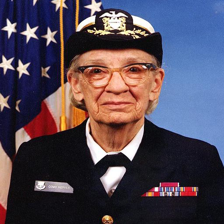

In [4]:
import numpy as np
import PIL.Image as Image

grace_hooper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hooper = Image.open(grace_hooper).resize((image_size, image_size))
grace_hooper

In [5]:
grace_hooper = np.array(grace_hooper)/255
grace_hooper.shape

(224, 224, 3)

In [6]:
result = model.predict(grace_hooper[np.newaxis,...])
result.shape

1/1 [==============================] - 8s 8s/step


(1, 1001)

In [7]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

10484/10484 [==============================] - 0s 0us/step


Text(0.5, 1.0, 'prediction:Military Uniform')

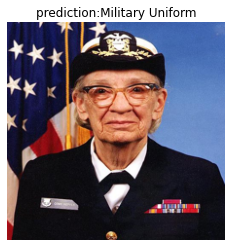

In [8]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
plt.imshow(grace_hooper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
plt.title('prediction:'+predicted_class_name.title())

In [9]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info = True,
    as_supervised = True,
    split=['train[:80%]','train[80%:]']
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteL0QKYY/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [10]:
for i , image in enumerate(train_examples.take(3)):
  print('Image {} shape: {}'.format(i+1, image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [11]:
def format_image(image, label):
  image = tf.image.resize(image, (image_size, image_size))/255
  return image, label

In [12]:
batch_size = 32
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(batch_size).prefetch(1)

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 538ms/step


array(['Gordon setter', 'Labrador retriever', 'Egyptian cat', 'beagle',
       'Egyptian cat', 'tabby', 'English springer',
       'American Staffordshire terrier', 'tabby', 'Angora',
       'Dandie Dinmont', 'tabby', 'chow', 'tiger cat', 'spatula',
       'Egyptian cat', 'golden retriever', 'miniature poodle',
       'Egyptian cat', 'English foxhound', 'tabby',
       'American Staffordshire terrier', 'Egyptian cat', 'Siamese cat',
       'redbone', 'Egyptian cat', 'kelpie', 'Egyptian cat',
       'English springer', 'tabby', 'Egyptian cat', 'tabby'], dtype='<U30')

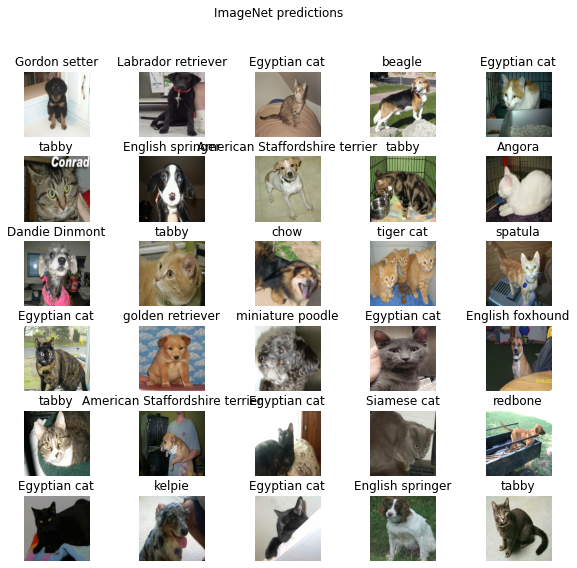

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape = (image_size, image_size ,3))

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [17]:
feature_extractor.trainable=False

In [20]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2, activation = 'softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [24]:
epochs = 6
history = model.fit(
    train_batches,
    epochs = epochs,
    validation_data = validation_batches
)

Epoch 1/6


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


582/582 [==============================] - 42s 59ms/step - loss: 0.0556 - accuracy: 0.9819 - val_loss: 0.0337 - val_accuracy: 0.9877
Epoch 2/6
582/582 [==============================] - 37s 57ms/step - loss: 0.0315 - accuracy: 0.9888 - val_loss: 0.0365 - val_accuracy: 0.9882
Epoch 3/6
582/582 [==============================] - 41s 63ms/step - loss: 0.0250 - accuracy: 0.9915 - val_loss: 0.0358 - val_accuracy: 0.9888
Epoch 4/6
582/582 [==============================] - 37s 57ms/step - loss: 0.0222 - accuracy: 0.9919 - val_loss: 0.0311 - val_accuracy: 0.9897
Epoch 5/6
582/582 [==============================] - 41s 63ms/step - loss: 0.0191 - accuracy: 0.9934 - val_loss: 0.0332 - val_accuracy: 0.9901
Epoch 6/6
582/582 [==============================] - 38s 59ms/step - loss: 0.0175 - accuracy: 0.9939 - val_loss: 0.0323 - val_accuracy: 0.9893


Text(0.5, 1.0, 'training and validation loss')

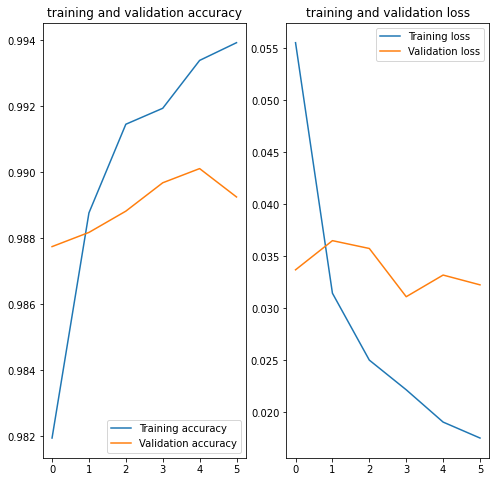

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label = 'Training accuracy')
plt.plot(epoch_range, val_acc, label = 'Validation accuracy')
plt.legend(loc='lower right')
plt.title('training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(epoch_range, loss, label = 'Training loss')
plt.plot(epoch_range, val_loss, label = 'Validation loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')

In [27]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [31]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_idx = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_idx]
predicted_class_names

1/1 [==============================] - 0s 46ms/step


array(['dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat',
       'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog',
       'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog',
       'cat', 'dog', 'cat', 'cat', 'cat'], dtype='<U3')

In [33]:
print('labels: ', label_batch)
print('predicted labels: ', predicted_class_names)

labels:  [1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0]
predicted labels:  ['dog' 'dog' 'cat' 'dog' 'cat' 'cat' 'dog' 'dog' 'cat' 'cat' 'dog' 'cat'
 'dog' 'cat' 'cat' 'cat' 'dog' 'dog' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat'
 'dog' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat']


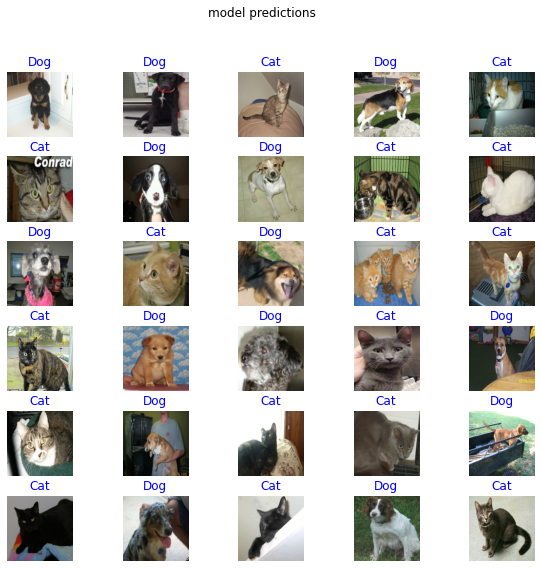

In [35]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color='blue' if predicted_idx[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
  plt.suptitle('model predictions')